In [ ]:
!tar -xf images.tar.gz

In [ ]:
!tar -xf annotations.tar.gz

In [1]:
import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
from keras import layers

In [2]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


In [3]:
target_img_paths

['annotations/trimaps/Abyssinian_1.png',
 'annotations/trimaps/Abyssinian_10.png',
 'annotations/trimaps/Abyssinian_100.png',
 'annotations/trimaps/Abyssinian_101.png',
 'annotations/trimaps/Abyssinian_102.png',
 'annotations/trimaps/Abyssinian_103.png',
 'annotations/trimaps/Abyssinian_104.png',
 'annotations/trimaps/Abyssinian_105.png',
 'annotations/trimaps/Abyssinian_106.png',
 'annotations/trimaps/Abyssinian_107.png',
 'annotations/trimaps/Abyssinian_108.png',
 'annotations/trimaps/Abyssinian_109.png',
 'annotations/trimaps/Abyssinian_11.png',
 'annotations/trimaps/Abyssinian_110.png',
 'annotations/trimaps/Abyssinian_111.png',
 'annotations/trimaps/Abyssinian_112.png',
 'annotations/trimaps/Abyssinian_113.png',
 'annotations/trimaps/Abyssinian_114.png',
 'annotations/trimaps/Abyssinian_115.png',
 'annotations/trimaps/Abyssinian_116.png',
 'annotations/trimaps/Abyssinian_117.png',
 'annotations/trimaps/Abyssinian_118.png',
 'annotations/trimaps/Abyssinian_119.png',
 'annotations/t

In [4]:
input_img_paths

['images/Abyssinian_1.jpg',
 'images/Abyssinian_10.jpg',
 'images/Abyssinian_100.jpg',
 'images/Abyssinian_101.jpg',
 'images/Abyssinian_102.jpg',
 'images/Abyssinian_103.jpg',
 'images/Abyssinian_104.jpg',
 'images/Abyssinian_105.jpg',
 'images/Abyssinian_106.jpg',
 'images/Abyssinian_107.jpg',
 'images/Abyssinian_108.jpg',
 'images/Abyssinian_109.jpg',
 'images/Abyssinian_11.jpg',
 'images/Abyssinian_110.jpg',
 'images/Abyssinian_111.jpg',
 'images/Abyssinian_112.jpg',
 'images/Abyssinian_113.jpg',
 'images/Abyssinian_114.jpg',
 'images/Abyssinian_115.jpg',
 'images/Abyssinian_116.jpg',
 'images/Abyssinian_117.jpg',
 'images/Abyssinian_118.jpg',
 'images/Abyssinian_119.jpg',
 'images/Abyssinian_12.jpg',
 'images/Abyssinian_120.jpg',
 'images/Abyssinian_121.jpg',
 'images/Abyssinian_122.jpg',
 'images/Abyssinian_123.jpg',
 'images/Abyssinian_124.jpg',
 'images/Abyssinian_125.jpg',
 'images/Abyssinian_126.jpg',
 'images/Abyssinian_127.jpg',
 'images/Abyssinian_128.jpg',
 'images/Abyssi

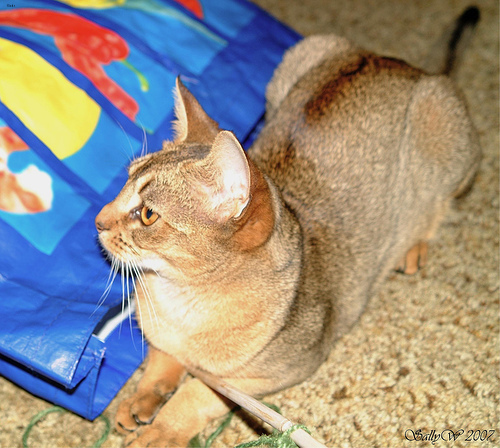

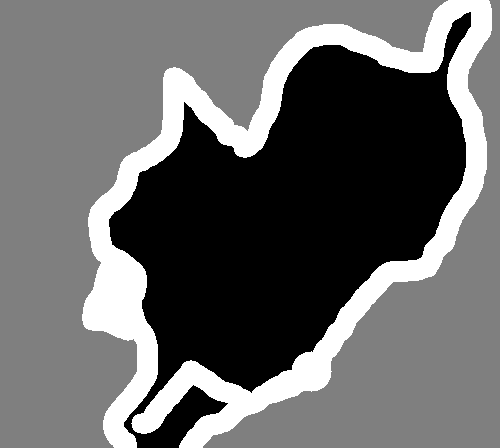

In [5]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

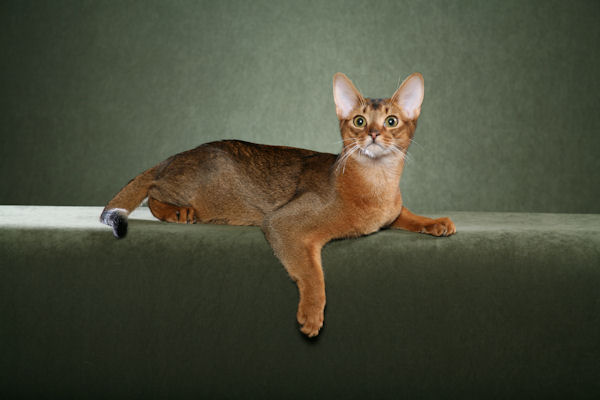

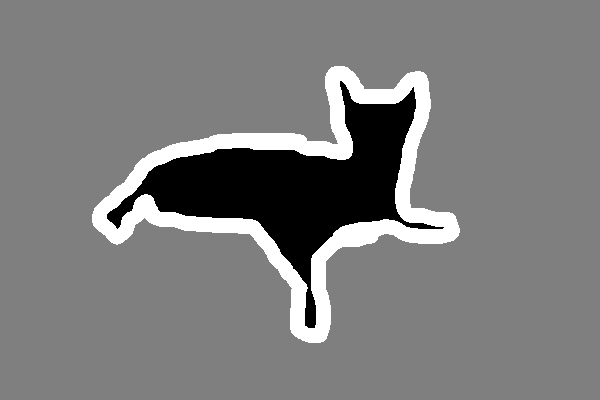

In [6]:
# Display input image #7
display(Image(filename=input_img_paths[0]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[0]))
display(img)

In [7]:
def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

In [8]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=1000,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

In [9]:
for i in train_dataset.take(1):
    print()
i

2024-12-25 13:19:17.356379: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(<tf.Tensor: shape=(32, 160, 160, 3), dtype=float32, numpy=
 array([[[[2.54971283e+02, 2.54971283e+02, 2.54971283e+02],
          [2.54388474e+02, 2.54388474e+02, 2.54388474e+02],
          [2.54368362e+02, 2.54368362e+02, 2.53743362e+02],
          ...,
          [2.54000000e+02, 2.54143555e+02, 2.51712891e+02],
          [2.54101364e+02, 2.54101364e+02, 2.52101364e+02],
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02]],
 
         [[2.53889252e+02, 2.53889252e+02, 2.53889252e+02],
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
          [2.54480072e+02, 2.54480072e+02, 2.54480072e+02],
          ...,
          [2.54259964e+02, 2.54259964e+02, 2.52259964e+02],
          [2.54494720e+02, 2.54494720e+02, 2.52494720e+02],
          [2.55000000e+02, 2.55000000e+02, 2.55000000e+02]],
 
         [[2.53512695e+02, 2.53512695e+02, 2.53512695e+02],
          [2.54680664e+02, 2.54680664e+02, 2.54680664e+02],
          [1.77392578e+02, 1.77392578e+02, 1.77392578e+02],
    

In [10]:
i[0].shape, i[1].shape

(TensorShape([32, 160, 160, 3]), TensorShape([32, 160, 160, 1]))

In [11]:
np.unique(i[1][0])

array([0, 1, 2], dtype=uint8)

In [12]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [14]:
i[0].shape

TensorShape([32, 160, 160, 3])

In [21]:
# Entry block
x1 = layers.Conv2D(32, 3, strides=2, padding="same")(i[0])
x2 = layers.BatchNormalization()(x1)
x = layers.Activation("relu")(x2)
previous_block_activation = x  # Set aside residual

In [22]:
i[0].shape, x1.shape, x2.shape, x.shape

(TensorShape([32, 160, 160, 3]),
 TensorShape([32, 80, 80, 32]),
 TensorShape([32, 80, 80, 32]),
 TensorShape([32, 80, 80, 32]))

In [23]:
for filters in [64, 128, 256]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    # Project residual
    residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

(32, 40, 40, 64)
(32, 40, 40, 64)
(32, 20, 20, 128)
(32, 20, 20, 128)
(32, 10, 10, 256)
(32, 10, 10, 256)


In [24]:
for filters in [64, 32]:
    x = layers.Activation("relu")(x)
    x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D(2)(x)
    # Project residual
    residual = layers.UpSampling2D(2)(previous_block_activation)
    residual = layers.Conv2D(filters, 1, padding="same")(residual)
    print(residual.shape)
    print(x.shape)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

(32, 20, 20, 64)
(32, 20, 20, 64)
(32, 40, 40, 32)
(32, 40, 40, 32)


In [25]:
# Add a per-pixel classification layer
outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
outputs.shape

TensorShape([32, 40, 40, 3])

In [26]:
# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 80, 80,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 80, 80,    │          0 │ activation_23[0]… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_12 │ (None, 80, 80,    │      2,400 │ activation_24[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_13 │ (None, 80, 80,    │      4,736 │ activation_25[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 40, 40,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 40, 40,    │      2,112 │ activation_23[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 40, 40,    │          0 │ max_pooling2d_6[… │
│                     │ 64)               │            │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 40, 40,    │          0 │ add_10[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_14 │ (None, 40, 40,    │      8,896 │ activation_26[0]… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 40, 40,    │          0 │ batch_normalizat

 Total params: 2,058,979 (7.85 MB)

 Trainable params: 2,055,203 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [29]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy"
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 50
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 85s - 3s/step - loss: 1.7190 - val_loss: 1.5308
Epoch 2/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 78s - 2s/step - loss: 0.9521 - val_loss: 1.5042
Epoch 3/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 75s - 2s/step - loss: 0.8222 - val_loss: 1.8575
Epoch 4/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 81s - 3s/step - loss: 0.7550 - val_loss: 2.3485
Epoch 5/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 82s - 3s/step - loss: 0.7083 - val_loss: 2.8231
Epoch 6/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 82s - 3s/step - loss: 0.6709 - val_loss: 3.2310
Epoch 7/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 85s - 3s/step - loss: 0.6381 - val_loss: 3.5558
Epoch 8/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 85s - 3s/step - loss: 0.6080 - val_loss: 3.7941
Epoch 9/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 76s - 2s/step - loss: 0.5796 - val_loss: 3.9379
Epoch 10/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 80s - 2s/step - loss: 0.5522 - val_loss: 4.0063
Epoch 11/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 84s - 3s/step - loss: 0.5252 - val_loss: 3.9901
Epoch 12/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 85s - 3s/step - loss: 0.4982 - val_loss: 3.9271
Epoch 13/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 78s - 2s/step - loss: 0.4710 - val_loss: 3.8481
Epoch 14/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 82s - 3s/step - loss: 0.4439 - val_loss: 3.7776
Epoch 15/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 80s - 2s/step - loss: 0.4172 - val_loss: 3.6271
Epoch 16/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 75s - 2s/step - loss: 0.3912 - val_loss: 3.4148
Epoch 17/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 84s - 3s/step - loss: 0.3670 - val_loss: 3.0395
Epoch 18/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 70s - 2s/step - loss: 0.3452 - val_loss: 2.5426
Epoch 19/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 67s - 2s/step - loss: 0.3273 - val_loss: 1.9611
Epoch 20/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 68s - 2s/step - loss: 0.3150 - val_loss: 1.4989
Epoch 21/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 75s - 2s/step - loss: 0.3187 - val_loss: 1.1047
Epoch 22/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 79s - 2s/step - loss: 0.3828 - val_loss: 1.4798
Epoch 23/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 81s - 3s/step - loss: 0.4656 - val_loss: 0.8104
Epoch 24/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 66s - 2s/step - loss: 0.3971 - val_loss: 1.0375
Epoch 25/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 68s - 2s/step - loss: 0.3878 - val_loss: 0.9367
Epoch 26/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 67s - 2s/step - loss: 0.3460 - val_loss: 0.8114
Epoch 27/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 72s - 2s/step - loss: 0.3104 - val_loss: 0.7559
Epoch 28/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 69s - 2s/step - loss: 0.3000 - val_loss: 0.7710
Epoch 29/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 67s - 2s/step - loss: 0.2943 - val_loss: 0.9233
Epoch 30/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 68s - 2s/step - loss: 0.3030 - val_loss: 0.8819
Epoch 31/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 67s - 2s/step - loss: 0.2761 - val_loss: 0.9408
Epoch 32/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 66s - 2s/step - loss: 0.2554 - val_loss: 1.0123
Epoch 33/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 72s - 2s/step - loss: 0.2465 - val_loss: 1.2121
Epoch 34/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 79s - 2s/step - loss: 0.2483 - val_loss: 1.5031
Epoch 35/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 71s - 2s/step - loss: 0.2571 - val_loss: 1.8682
Epoch 36/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 72s - 2s/step - loss: 0.2695 - val_loss: 1.4484
Epoch 37/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 69s - 2s/step - loss: 0.2832 - val_loss: 0.9135
Epoch 38/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 77s - 2s/step - loss: 0.2532 - val_loss: 1.0409
Epoch 39/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 74s - 2s/step - loss: 0.2276 - val_loss: 1.0115
Epoch 40/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 92s - 3s/step - loss: 0.2061 - val_loss: 0.9854
Epoch 41/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 81s - 3s/step - loss: 0.1939 - val_loss: 1.0916
Epoch 42/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 82s - 3s/step - loss: 0.1863 - val_loss: 1.1242
Epoch 43/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 78s - 2s/step - loss: 0.1822 - val_loss: 1.1249
Epoch 44/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 95s - 3s/step - loss: 0.1804 - val_loss: 1.1416
Epoch 45/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 72s - 2s/step - loss: 0.1830 - val_loss: 1.1368
Epoch 46/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 80s - 2s/step - loss: 0.1892 - val_loss: 1.3296
Epoch 47/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 85s - 3s/step - loss: 0.2039 - val_loss: 1.6877
Epoch 48/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 79s - 2s/step - loss: 0.2173 - val_loss: 1.8309
Epoch 49/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 91s - 3s/step - loss: 0.2205 - val_loss: 1.7371
Epoch 50/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 74s - 2s/step - loss: 0.2230 - val_loss: 1.3342


32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step


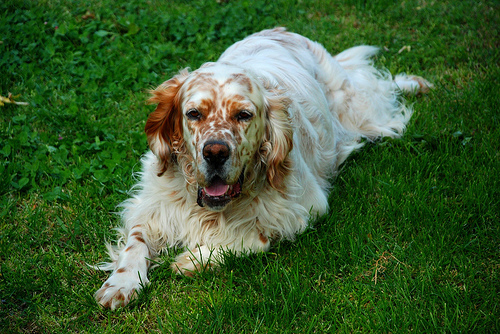

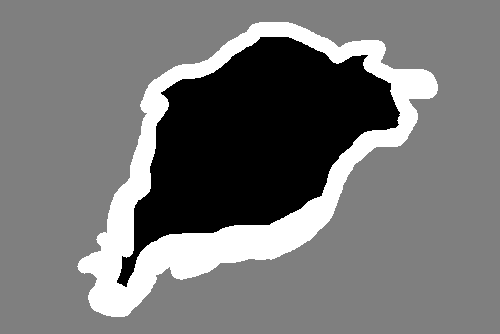

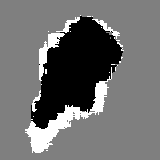

In [31]:
# Generate predictions for all images in the validation set

val_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
val_preds = model.predict(val_dataset)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 100

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.